# Simple speech recognition

Audio 데이터를 다뤄서 학습하는 방법을 배워보도록 합시다.
머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.
* tensorflow 2.1 버전에 최적화되어있습니다.

## Project 설명
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.

### Baseline
* 기본적으로 사용하는 Convulution layers를 구성해 사용해보자.
    * ex) Conv - Conv - pooling - FC layers
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * tf.data.dataset과 model.fit()을 사용
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Setting tensorflow version

In [0]:
!pip install tensorflow-gpu==2.1

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__

'2.2.0'

## Import modules

### Import colab modules for Google Colab (if necessary)

In [0]:
use_colab = True
assert use_colab in [True, False]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Unfortunately you cannot downlaod GIANA dataset from website
# So I upload zip file on my dropbox
# if you want to download from my dropbox uncomment below  
if use_colab:
    DATASET_PATH='./drive/My Drive/datasets'
else:
    DATASET_PATH='./datasets'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

    import urllib.request
    u = urllib.request.urlopen(url='http://bigfile.mail.naver.com/bigfileupload/download?fid=8XYZaAIq1NKmKqujKCYXKxKrFqKjKogZKAg9Kx2waxUmKqKjKxElKotmFxvla3e4KzUrK6KXK4UmFxiCMoU9KrudpoivaxpCFqblpAEZMm==')
    data = u.read()
    u.close()
    
else:
    print('Data has already been downloaded and extracted.')

### Load dataset

In [8]:
ls

drive/  sample_data/


In [0]:
cd '/content/drive/My Drive/'

/content/drive/My Drive


In [0]:
!wget http://bigfile.mail.naver.com/bigfileupload/download?fid=8XYZaAIq1NKmKqujKCYXKxKrFqKjKogZKAg9Kx2waxUmKqKjKxElKotmFxvla3e4KzUrK6KXK4UmFxiCMoU9KrudpoivaxpCFqblpAEZMm==

--2020-05-26 01:47:10--  http://bigfile.mail.naver.com/bigfileupload/download?fid=8XYZaAIq1NKmKqujKCYXKxKrFqKjKogZKAg9Kx2waxUmKqKjKxElKotmFxvla3e4KzUrK6KXK4UmFxiCMoU9KrudpoivaxpCFqblpAEZMm==
Resolving bigfile.mail.naver.com (bigfile.mail.naver.com)... 125.209.234.99
Connecting to bigfile.mail.naver.com (bigfile.mail.naver.com)|125.209.234.99|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 1621257882 (1.5G) [application/octet-stream]
Saving to: ‘download?fid=8XYZaAIq1NKmKqujKCYXKxKrFqKjKogZKAg9Kx2waxUmKqKjKxElKotmFxvla3e4KzUrK6KXK4UmFxiCMoU9KrudpoivaxpCFqblpAEZMm==’

download?fid=8XYZaA 100%[===================>]   1.51G  11.1MB/s    in 2m 26s  

2020-05-26 01:49:37 (10.6 MB/s) - ‘download?fid=8XYZaAIq1NKmKqujKCYXKxKrFqKjKogZKAg9Kx2waxUmKqKjKxElKotmFxvla3e4KzUrK6KXK4UmFxiCMoU9KrudpoivaxpCFqblpAEZMm==’ saved [1621257882/1621257882]



In [0]:
!mv dow* speech_wav_8000.npz

In [0]:
speech_data = np.load("/content/drive/My Drive/datasets/speech_wav_8000.npz")

In [5]:
speech_data['wav_vals'][0].shape

(8000,)

In [6]:
# 오디오 실행해보기 
# rate 비율을 조절하여 길이를 늘릴수 있다,
import IPython.display as ipd
ipd.Audio(speech_data['wav_vals'][0],rate= 8000)

In [7]:
speech_data['label_vals']

array([['down'],
       ['down'],
       ['down'],
       ...,
       ['silence'],
       ['silence'],
       ['silence']], dtype='<U7')

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.

In [94]:
# 데이터를 정리하는 과정
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                speech_data["label_vals"], 
                                                                test_size=0.1,
                                                                shuffle=True)

train_wav = train_wav.reshape(-1,sr,1)
test_wav = test_wav.reshape(-1,sr,1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

(45558, 8000, 1)
(5062, 8000, 1)
(45558, 1)
(5062, 1)


In [95]:
len(train_wav)

45558

In [96]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
# 내가 학습할것 외에는 아래와 같이 분류 하겠다.
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

# loss를 구하기 위해 단어들을 인덱싱 해준다.
label_value

{'down': 3,
 'go': 9,
 'left': 4,
 'no': 1,
 'off': 7,
 'on': 6,
 'right': 5,
 'silence': 11,
 'stop': 8,
 'unknown': 10,
 'up': 2,
 'yes': 0}

In [0]:
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

In [98]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (45558, 8000, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 8000, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


### Hyper-parameters setting

In [0]:
batch_size = 512 # 8000 * 1
max_epochs = 30 #
drop_out_rate = 0.5

# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/wave/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'wave/exp1'

In [0]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [0]:
def add_noise (wav, label) :
  train_wav += 0.001
  return wav, label

In [108]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label)) #
train_dataset = train_dataset.map(one_hot_label)
# train_dataset = train_dataset.map(함수) 함수를 통하여 noise를 추가하든 우리가 했던 datagenerator 효과를 줄 수 있다.
# 위의 add_noise 함수 처럼,

# repeat().batch(batch_size=batch_size)가 뭔지 알아보자


train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [109]:
# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))#
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


### Model 구현
* Wave 파일 데이터를 이용해 학습을 할 수 있는 모델을 구현합니다.

In [0]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

In [0]:
optimizer= tf.optimizers.Adam(learning_rate=0.001)
model.compile(loss= tf.keras.losses.categorical_crossentropy, 
              # 이전 예제에선 binary croos entropy 를 사용했으면, 이번에는 categorical crossentropy 를 사용
             optimizer=optimizer,
             metrics=['accuracy'])

In [112]:
# without training, just inference a model in eager execution:
# model summary 를 하기 위함
# 왜냐면 model은 call 을 한번 해줘야 생성되기 때문
predictions = model(train_wav[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.08326776 0.08277929 0.08320757 0.08342989 0.08356518 0.08303192
  0.08332034 0.08332048 0.08326625 0.08399452 0.08292887 0.08388793]]


### 구성된 모델 확인

In [113]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3995, 8)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 3995, 8)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1994, 16)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1994, 16)          0  

### 모델 학습

In [114]:
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,#,
                    steps_per_epoch=len(train_wav)//batch_size, #,
                    validation_data=test_dataset,#,
                    validation_steps=len(test_wav)//batch_size,#,
                    )

Epoch 1/30
88/88 [==============================] - 16s 186ms/step - loss: 2.3578 - accuracy: 0.1570 - val_loss: 2.3350 - val_accuracy: 0.2142
Epoch 2/30
88/88 [==============================] - 16s 183ms/step - loss: 2.1355 - accuracy: 0.2314 - val_loss: 2.0800 - val_accuracy: 0.2420
Epoch 3/30
88/88 [==============================] - 16s 181ms/step - loss: 1.8565 - accuracy: 0.3224 - val_loss: 1.7717 - val_accuracy: 0.3611
Epoch 4/30
88/88 [==============================] - 16s 181ms/step - loss: 1.6768 - accuracy: 0.3858 - val_loss: 1.6054 - val_accuracy: 0.4494
Epoch 5/30
88/88 [==============================] - 16s 181ms/step - loss: 1.5656 - accuracy: 0.4310 - val_loss: 1.5575 - val_accuracy: 0.4653
Epoch 6/30
88/88 [==============================] - 16s 180ms/step - loss: 1.4813 - accuracy: 0.4644 - val_loss: 1.5333 - val_accuracy: 0.4796
Epoch 7/30
88/88 [==============================] - 16s 181ms/step - loss: 1.4160 - accuracy: 0.4940 - val_loss: 1.4886 - val_accuracy: 0.4974

In [0]:
# history 저장
train_1 = history

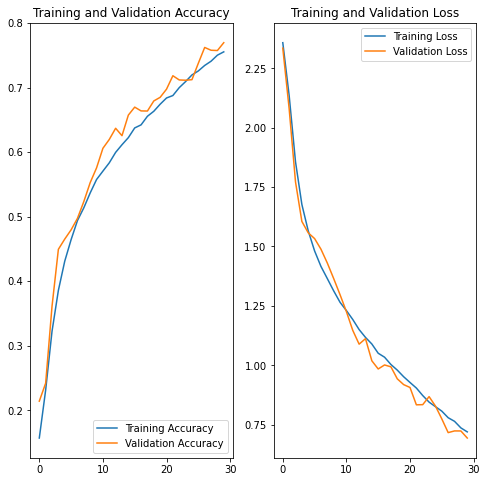

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [117]:
results = model.evaluate(test_dataset)

10/10 [==============================] - 1s 68ms/step - loss: 0.7022 - accuracy: 0.7653
